# A first look convnet



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai import *
from fastai.vision import *

from glob import glob

%matplotlib inline


In [0]:
%cd /content/drive/My\ Drive/alfalfa-convnets

PATH = os.path.abspath('.')

/content/drive/My Drive/alfalfa-convnets


# Making the toy catalog

In [0]:
df = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv')
df.sample(5)

,GASS,AGCnr,SDSS,PLATEID,MJD,FIBERID,RA,DEC,zSDSS,Dlum,lgMstar,expAB_r,model_r,merr_r,ext_r,petrR50_r,petrR90_r,petrR50_z,lgmust,CINDX,INCL,NUVr,lgSFR_tot_median,SFR_best,SFRerr_best,SFRcase_best,HIsrc,HI_FLAG,xGASSDR,zHI,W50cor,lgMHI,lgGF,HIconf_flag,weight,group_id_B,NYU_id,env_code_B,Ngal_B,yang_shred_code,logMh_Mst_B,lvir_ratB
779,113010,0,J135305.43+155040.3,2742,54233,36,208.27263,15.84455,0.010214,44.1,9.979980,0.476738,13.8633,0.0020,0.0809,5.12,15.05,4.82,9.17,2.94,63.8,4.35,-0.470736,0.106702,0.071554,1,3,1,4,0.010237,267.0,8.526,-1.454,0.0,1.308,455561,2382333,1,1,0,0.0000,-99.000000
738,113000,231342,J131936.84+030157.3,526,52312,413,199.90353,3.03260,0.019746,85.9,10.072838,0.761388,14.1193,0.0020,0.0683,4.16,12.02,3.98,8.87,2.89,41.4,2.92,0.307823,1.832144,0.197984,1,1,0,0,0.019700,250.0,9.400,-0.673,0.0,0.655,21352,289410,2,2,0,11.7339,-1.642275
724,40570,230142,J131104.94+084828.3,1796,53884,90,197.77060,8.80787,0.032530,142.8,11.141000,0.613231,13.5074,0.0019,0.0801,6.61,18.64,6.20,9.13,2.82,53.7,5.97,-0.989147,0.105140,0.162696,2,4,99,1,0.000000,0.0,9.204,-1.937,-99.0,0.169,14981,1333248,2,3,0,12.8793,-1.367715
297,20144,192359,J093502.01+095512.4,1303,53050,571,143.75840,9.92012,0.049610,220.5,10.065000,0.852598,16.3466,0.0050,0.0809,4.08,7.39,3.76,8.14,1.81,32.2,2.74,-0.171311,0.764490,0.000000,9,3,1,1,0.049618,79.0,9.346,-0.719,0.0,0.655,32345,1075391,0,2,0,12.1033,-0.484111
980,10145,242663,J145806.39+040603.6,589,52055,356,224.52663,4.10101,0.044420,196.7,11.060000,0.834089,14.3723,0.0021,0.1546,4.57,15.21,4.12,9.15,3.33,34.3,4.40,-0.778521,1.053011,0.000000,9,3,1,1,0.044464,277.0,9.614,-1.446,0.0,0.178,129220,491477,1,1,0,12.6998,-4.160838


**Note** Some of these are non-detections (`HIconf_flag` is -99) or are confused (`HI_FLAG` is 3 or 5).

In [0]:
ids = np.array([os.path.basename(fn).strip('.jpg') for fn in glob(f'{PATH}/images-xGASS/*.jpg')], dtype=int)
print(ids[:5])

[ 10031   3936  13227 110063   3777]


In [0]:
len(ids), len(df)

(1179, 1179)

In [0]:
# make log HI gas fraction column (including upper limits)
df['logfgas'] = df.lgMHI - df.lgMstar

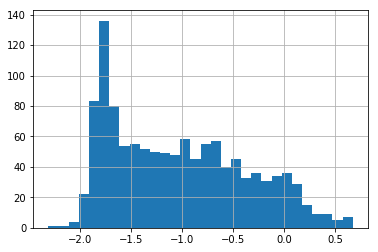

In [0]:
df.logfgas.hist(bins=30)

In [0]:
# stats computed from a single batch of SDSS images (xGASS)
xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

# Compile DataBunch

In [0]:
bs = 256
sz = 224

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-xGASS', suffix='.jpg', cols='GASS')
                .split_by_rand_pct(0.2)
                .label_from_df(cols='logfgas',  label_cls=FloatList)
      )

In [0]:
data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats))

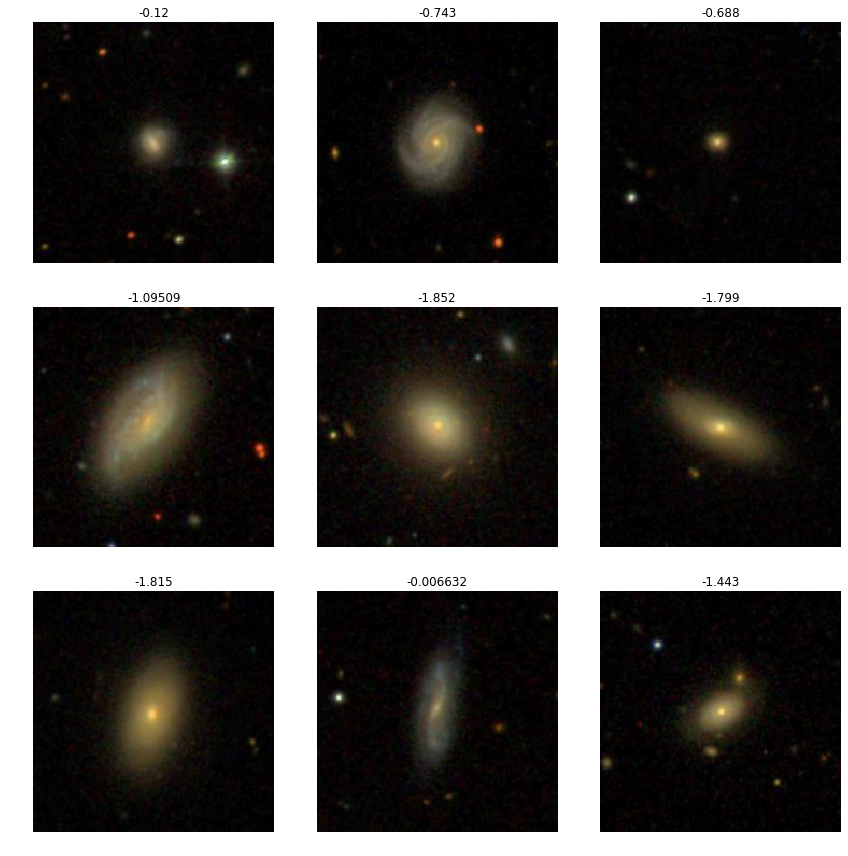

In [0]:
data.show_batch(3, figsize=(12, 12))

In [0]:
learn = cnn_learner(data, base_arch=models.resnet18, pretrained=True, loss_func=root_mean_squared_error)

In [0]:
learn.fit(1, 0.03)

epoch,train_loss,valid_loss,time
0,2.510846,2.937807,01:14


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


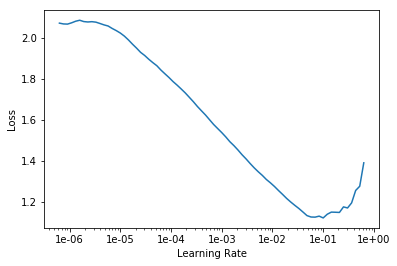

In [0]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(50, slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,time
0,1.984145,1.195734,00:09
1,1.749365,0.960447,00:09
2,1.623326,1.353737,00:09
3,1.518819,1.546120,00:09
4,1.411093,1.269303,00:09
5,1.319024,0.769579,00:09
6,1.238102,0.543967,00:09
7,1.161559,0.588629,00:09
8,1.100722,0.515639,00:09
9,1.042618,0.462192,00:09


In [0]:
learn.save('xGASS_resnet18-50ep')

(0.3, 0.8)

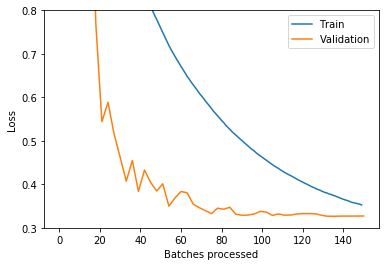

In [0]:
learn.recorder.plot_losses()
plt.ylim(0.3, 0.8)

In [0]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def offset_image(objID, zoom=0.1):
    return OffsetImage(image2np(open_image(f'{PATH}/images-xGASS/{objID}.jpg').data), zoom=zoom)

def plot_results(results, show_images=True):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.scatter('fgas_true', 'fgas_pred', data=results, c='black')

    if show_images:
        artists = []
        for objID, [Z_true, Z_pred] in results.sample(100).iterrows():
            ab = AnnotationBbox(offset_image(objID, zoom=0.4), (Z_true, Z_pred), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
            
    # plot 1:1 line
    plt.plot([-4, 4], [-4, 4], c='C3', ls='--', lw='10')

    ax.set_xlim(-2., 0.5)
    ax.set_ylim(-2., 0.5)
    ax.set_xlabel(r'True log $\mu_{\rm gas}$')
    ax.set_ylabel(r'Pred log $\mu_{\rm gas}$')



In [0]:
fgas_pred, fgas_true = learn.TTA()

# store results, along with AGC identifier, in new DataFrame
results = pd.DataFrame({'fgas_true': fgas_true.squeeze(), 'fgas_pred': fgas_pred.squeeze()})
results['GASS'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('GASS', drop=True, inplace=True)

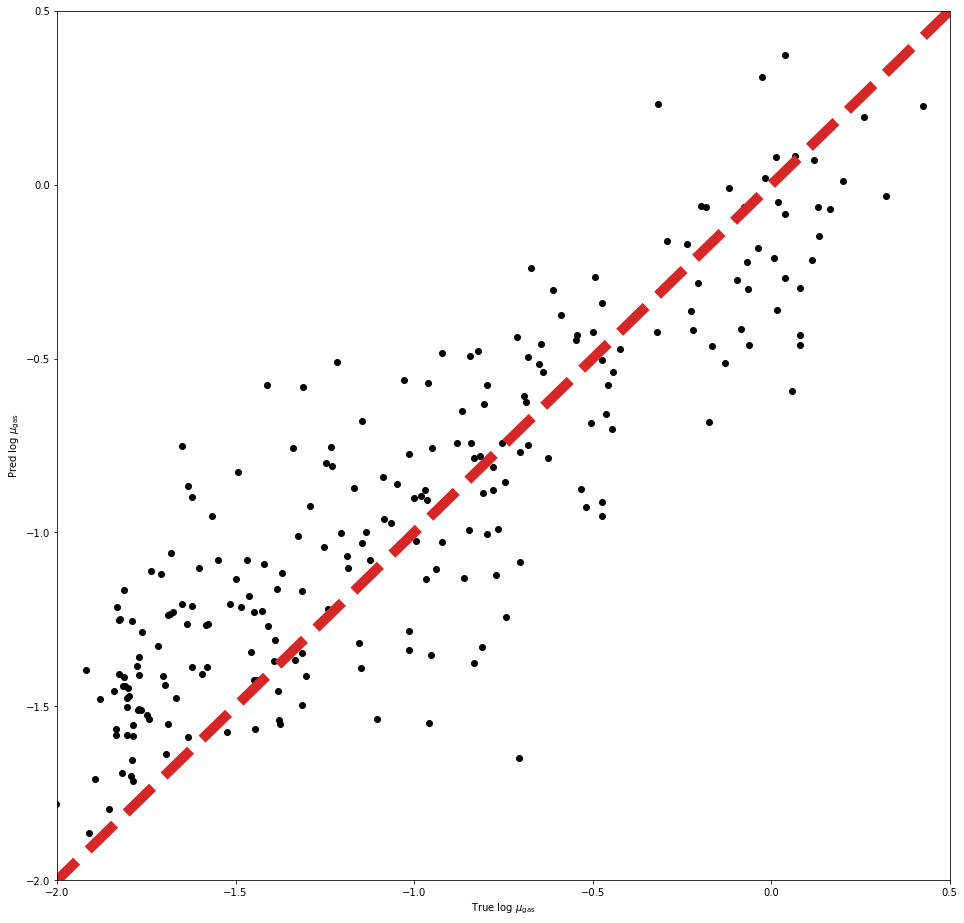

In [0]:
plot_results(results, show_images=False)

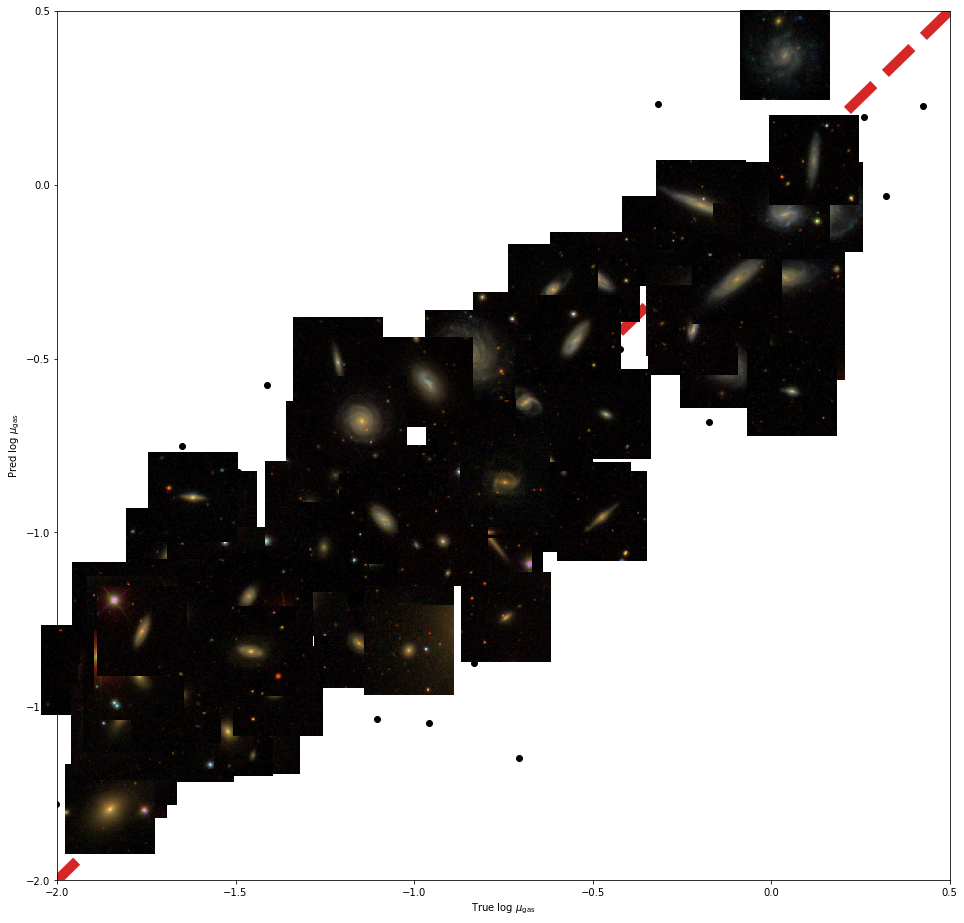

In [0]:
plot_results(results, show_images=True)

## Use deeper network (resnet 34)

In [0]:
bs = 128
sz = 224

src = (ImageList.from_df(df, path=PATH, folder='images-xGASS', suffix='.jpg', cols='GASS')
                .split_by_rand_pct(0.2)
                .label_from_df(cols='log_fgas',  label_cls=FloatList)
      )

data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats))

In [0]:
learn = cnn_learner(data, base_arch=models.resnet34, pretrained=True, loss_func=root_mean_squared_error)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 72673862.23it/s]


epoch,train_loss,valid_loss,time
0,2.622631,1.232783,00:14


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


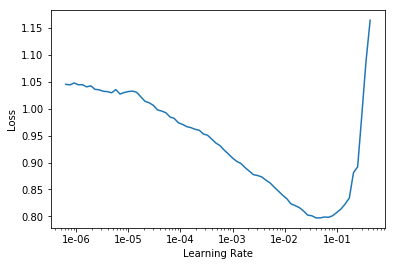

In [0]:
learn.fit(1, 0.03)
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(50, slice(3e-5, 3e-3))

epoch,train_loss,valid_loss,time
0,0.996451,0.756424,00:11
1,0.924410,0.930582,00:11
2,0.869754,0.868271,00:11
3,0.824737,0.692783,00:11
4,0.787211,0.688834,00:11
5,0.756520,0.680714,00:11
6,0.728963,0.619596,00:11
7,0.694888,0.539963,00:11
8,0.665021,0.396666,00:11
9,0.638280,0.426904,00:11


(0.2, 0.5)

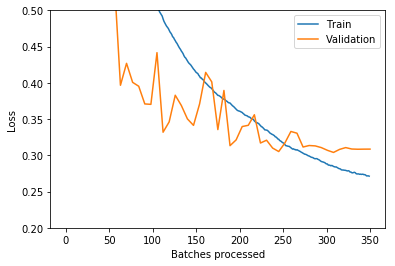

In [0]:
learn.recorder.plot_losses()
plt.ylim(0.2, 0.5)

In [0]:
learn.save('xGASS_resnet34-50ep')

# Train a resnet50

In [0]:
bs = 64
sz = 224

src = (ImageList.from_df(df, path=PATH, folder='images-xGASS', suffix='.jpg', cols='GASS')
                .split_by_rand_pct(0.2)
                .label_from_df(cols='log_fgas',  label_cls=FloatList)
      )

data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats))

In [0]:
learn = cnn_learner(data, base_arch=models.resnet50, pretrained=True, loss_func=root_mean_squared_error)

In [0]:
learn.fit_one_cycle(1, 0.03)

epoch,train_loss,valid_loss,time
0,1.255167,0.691639,00:26


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


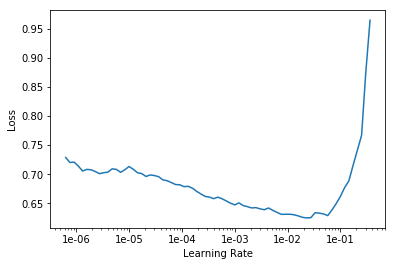

In [0]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(50, slice(3e-5, 3e-3))

epoch,train_loss,valid_loss,time
0,0.667023,0.672326,00:20
1,0.623172,0.584996,00:20
2,0.591784,0.435772,00:20
3,0.563251,0.382370,00:20
4,0.544028,0.380626,00:20
5,0.523183,0.434027,00:20
6,0.507279,0.381574,00:20
7,0.490375,0.419095,00:20
8,0.471874,0.448877,00:20
9,0.459187,0.360320,00:20


In [0]:
learn.save('xGASS_resnet50-50ep')

In [0]:
fgas_pred, fgas_true = learn.TTA()

# store results, along with AGC identifier, in new DataFrame
results = pd.DataFrame({'fgas_true': fgas_true.squeeze(), 'fgas_pred': fgas_pred.squeeze()})
results['GASS'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('GASS', drop=True, inplace=True)

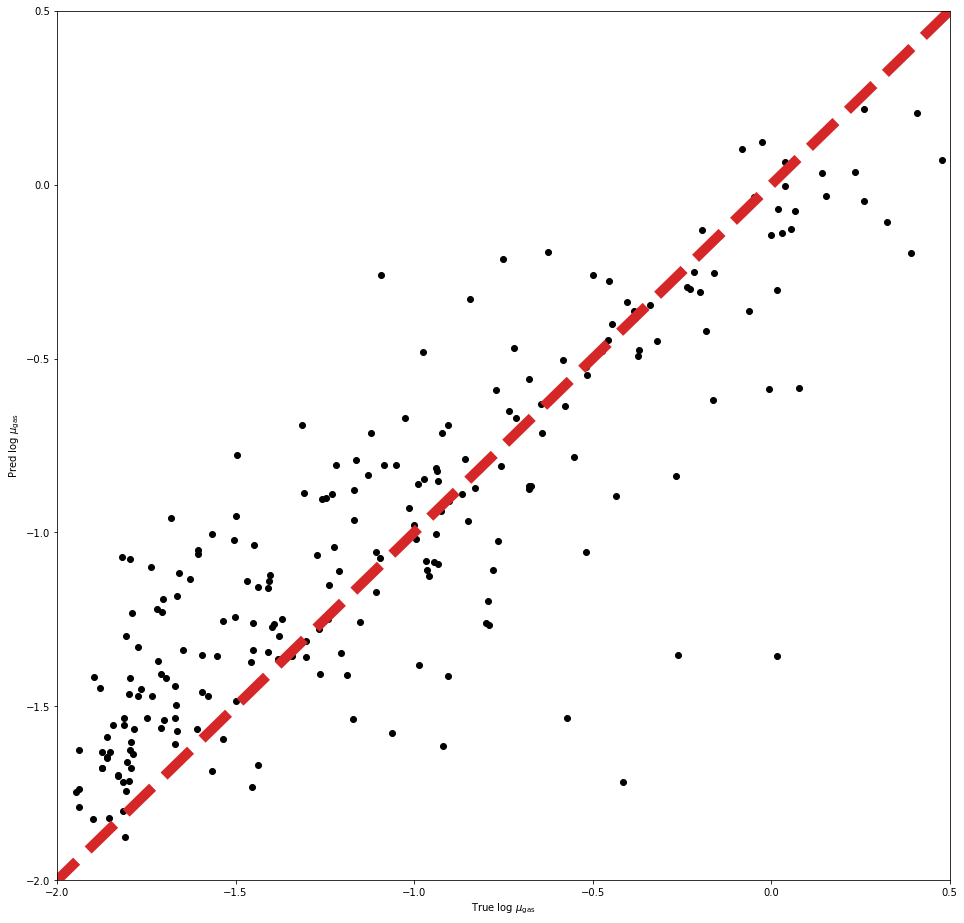

In [0]:
plot_results(results, show_images=False)

In [0]:
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.3735)

Seems like resnet-34 > resnet-18 > resnet-50 (given the same number of training epochs)

# Train an xresnet18

In [0]:
bs = 128
sz = 224

data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats))

In [0]:
learn = Learner(data, models.xresnet34(c_out=1), loss_func=root_mean_squared_error, wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


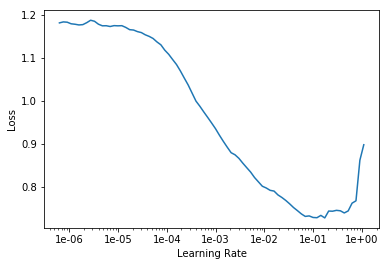

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(150, 5e-3)

epoch,train_loss,valid_loss,time
0,0.824411,1.181779,00:13
1,0.660903,1.041588,00:12
2,0.601002,0.945030,00:12
3,0.561397,0.781507,00:12
4,0.523605,0.562863,00:12
5,0.493966,0.525983,00:12
6,0.471562,0.490854,00:12
7,0.451375,0.495028,00:12
8,0.434508,0.446519,00:12
9,0.422291,0.436254,00:12


(0.2, 0.6)

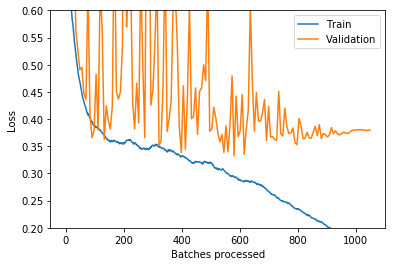

In [0]:
learn.recorder.plot_losses()
plt.ylim(0.2, 0.6)

Note that I trained with wd=5e-3 and lr=3e-3 for 150 epochs. This resulted in pretty poor performance (overfitting)...

In [0]:
learn.save('xGASS_xresnet18-150ep')

In [0]:
fgas_pred, fgas_true = learn.TTA()

# store results, along with AGC identifier, in new DataFrame
results = pd.DataFrame({'fgas_true': fgas_true.squeeze(), 'fgas_pred': fgas_pred.squeeze()})
results['GASS'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('GASS', drop=True, inplace=True)

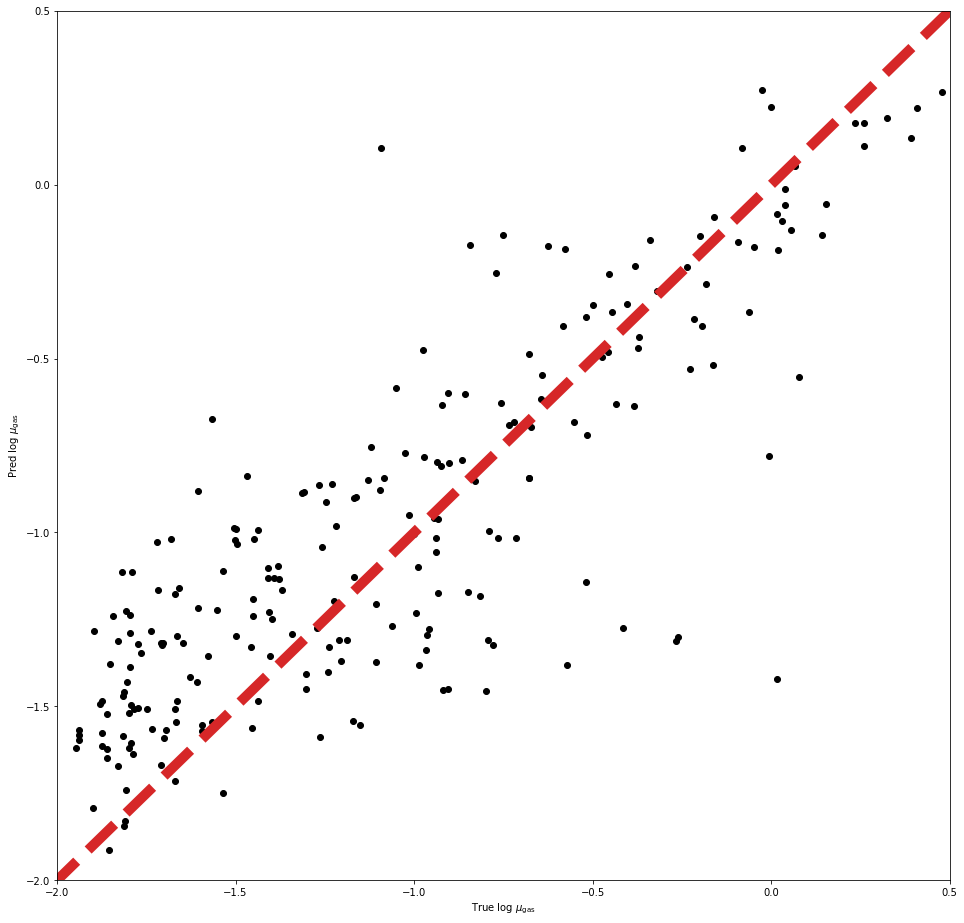

In [0]:
plot_results(results, show_images=False)

# Fine-tune a pretrained resnet34

In [0]:
bs = 128
sz = 224

In [0]:
df_a40 = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

# get Zgas closer to a median of 0
df_a40.Zgas -= 8.8


src_a40 = (ImageList.from_df(df_a40, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                    .split_by_rand_pct(0.2)
                    .label_from_df(cols=['logfgas', 'logsSFR', 'logMstar', 'Zgas'],  label_cls=FloatList)
          )

In [0]:
data_a40 = (src_a40.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
                .databunch(bs=bs)
                .normalize(xGASS_stats)
           )

In [0]:
# load pretrained model on ALFALFA.40
learn = cnn_learner(data_a40, base_arch=models.resnet34, pretrained=False, loss_func=root_mean_squared_error)
learn.load('a.40_all-galaxy-properties_resnet34-40ep');

In [0]:
df = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv')
df['logfgas'] = df.lgMHI - df.lgMstar


src = (ImageList.from_df(df, path=PATH, folder='images-xGASS', suffix='.jpg', cols='GASS')
                .split_by_rand_pct(0.2)
                .label_from_df(cols='logfgas',  label_cls=FloatList)
      )

data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
# since it used to predict 4 quantities, now we want it to predict only 1
learn.model[-1] = nn.Sequential(*learn.model[-1], nn.Linear(in_features=4, out_features=1, bias=True).cuda())

learn.data = data

In [119]:
learn.freeze()
learn.fit(1, 3e-2)

epoch,train_loss,valid_loss,time
0,1.521179,1.667323,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


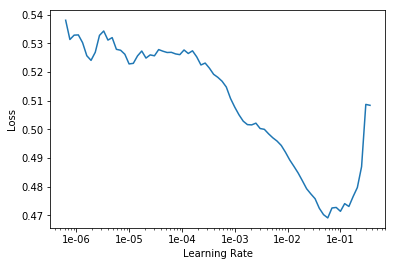

In [120]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.load('tmp');

In [132]:
learn.fit_one_cycle(30, 1e-2, pct_start=0.1)

epoch,train_loss,valid_loss,time
0,0.505758,0.640494,00:06
1,0.477157,0.564952,00:07
2,0.451205,0.595699,00:07
3,0.428566,0.401976,00:07
4,0.414522,0.368367,00:07
5,0.403995,0.381514,00:07
6,0.393020,0.325079,00:07
7,0.384173,0.375964,00:07
8,0.379479,0.322147,00:07
9,0.371811,0.353208,00:07


Wow this ends up being better than immediately unfreezing -- shows that "fine-tuning" is often the way to go!

## Unfreezing immediately (as proof of concept)

In [0]:
# load pretrained model on ALFALFA.40
learn = cnn_learner(data_a40, base_arch=models.resnet34, pretrained=False, loss_func=root_mean_squared_error)
learn.load('a.40_all-galaxy-properties_resnet34-40ep');

In [0]:
df = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv')
df['logfgas'] = df.lgMHI - df.lgMstar


src = (ImageList.from_df(df, path=PATH, folder='images-xGASS', suffix='.jpg', cols='GASS')
                .split_by_rand_pct(0.2)
                .label_from_df(cols='logfgas',  label_cls=FloatList)
      )

data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
# since it used to predict 4 quantities, now we want it to predict only 1
learn.model[-1] = nn.Sequential(*learn.model[-1], nn.Linear(in_features=4, out_features=1, bias=True).cuda())

learn.data = data

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


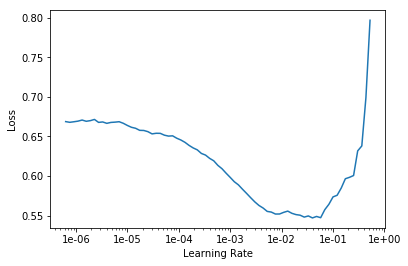

In [81]:
learn.lr_find()
learn.recorder.plot()

In [82]:
learn.fit_one_cycle(50, slice(3e-5, 1e-3))

epoch,train_loss,valid_loss,time
0,0.662406,1.012913,00:07
1,0.651991,1.029772,00:08
2,0.637321,1.010252,00:08
3,0.619105,0.946747,00:08
4,0.599696,0.771078,00:08
5,0.575390,0.475424,00:07
6,0.546839,0.392617,00:08
7,0.514713,0.330962,00:07
8,0.485421,0.305055,00:07
9,0.459372,0.432690,00:07


(0.2, 0.6)

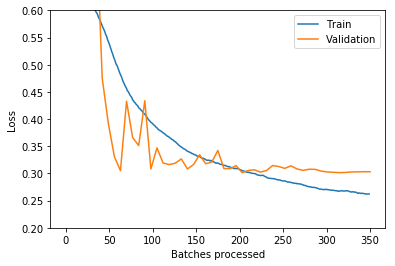

In [83]:
learn.recorder.plot_losses()
plt.ylim(0.2, 0.6)

In [0]:
learn.save('xGASS_resnet34-50ep_finetune-from-a40-multipredict')

## Same transfer learning, except using single $\alpha$.40 $f_{\rm gas}$ prediction (not good)

In [0]:
learn.load('a.40_fgas_resnet34-40ep');

In [0]:
df = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv')
df['log_fgas'] = df.lgMHI - df.lgMstar


src = (ImageList.from_df(df, path=PATH, folder='images-xGASS', suffix='.jpg', cols='GASS')
                .split_by_rand_pct(0.2)
                .label_from_df(cols='log_fgas',  label_cls=FloatList)
      )
data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats))

learn.data = data

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


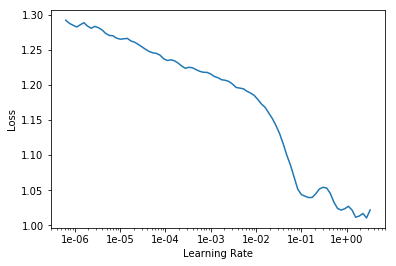

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(50, slice(3e-4, 3e-2))

epoch,train_loss,valid_loss,time
0,1.191180,1.392976,00:07
1,1.165363,1.411472,00:07
2,1.132097,1.493023,00:07
3,1.089273,1.360716,00:08
4,1.034743,1.030303,00:08
5,0.958857,0.699401,00:08
6,0.865330,0.637516,00:08
7,0.767596,0.519070,00:08
8,0.690848,1.357763,00:07
9,0.636683,0.448017,00:08


In [0]:
learn.recorder.plot_losses()
plt.ylim(0.2, 0.6)

In [0]:
learn.save('xGASS_resnet34-50ep_finetune-from-a40')

# Transfer learn from trained metallicity prediction convnet?